<a href="https://colab.research.google.com/github/farkhanAdhitama/deteksi_kerusakan_jalan_yolov9/blob/main/FIX_SKRIPSI_Deteksi_Kerusakan_Jalan_YOLOv5s_(512x512_fit_in_16_batch_150_epoch_hyp_default).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deteksi Kerusakan Jalan YOLOv5s




image size : 512x512 fit in\
epoch : 150 \
batch : 16 \
lr : default

# GPU Check

In [1]:
!nvidia-smi

Sun Jun 30 22:14:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Install YOLOv5

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

Cloning into 'yolov5'...
remote: Enumerating objects: 16726, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 16726 (delta 140), reused 155 (delta 83), pack-reused 16459
Receiving objects: 100% (16726/16726), 15.39 MiB | 25.71 MiB/s, done.
Resolving deltas: 100% (11439/11439), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 75.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fo

In [4]:
import torch
import os
from IPython.display import Image, clear_output

In [5]:
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.3.0+cu121 (Tesla T4)


# Download Data

Dataset disimpan dalam folder {HOME}/yolov9 agar bisa dilakukan proses pelatihan

In [6]:
%cd {HOME}/yolov5

/content/yolov5


In [7]:
from roboflow import Roboflow
rf = Roboflow(api_key="mKfBaoS5ZsLfPjDXBp1i")
project = rf.workspace("muhammadfarkhan").project("deteksi-kerusakan-jalan-qndim")
version = project.version(20)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Deteksi-Kerusakan-Jalan-20 in yolov5pytorch:: 100%|██████████| 6654/6654 [00:00<00:00, 7820.43it/s]


## Distribusi Dataset
Dataset dibagi menjadi 80% data training, 10% data validation, dan 10% data testing. Total 3321 dataset gambar.

In [8]:
import os
from collections import Counter
import matplotlib.pyplot as plt
from collections import Counter

**Distribusi Data Training**

{'alligator_cracking': 773, 'lateral_cracking': 925, 'longitudinal_cracking': 1766, 'pothole': 2105}


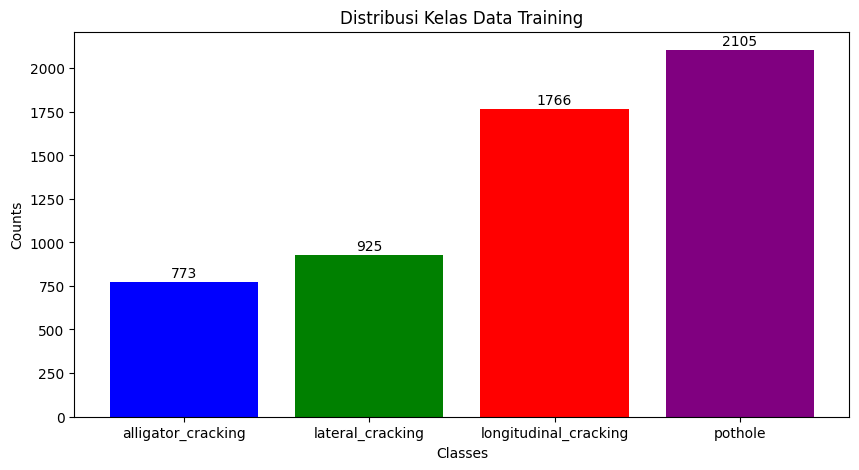

In [9]:
annotations_path = os.path.join(dataset.location, 'train/labels')

class_names = {
    0: "alligator_cracking",
    1: "lateral_cracking",
    2: "longitudinal_cracking",
    3: "pothole"
}

class_counter = Counter()
for filename in os.listdir(annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                class_counter[class_id] += 1

# Mapping hasil ke nama kelas dan mengurutkannya
sorted_class_counts = {class_names[k]: class_counter[k] for k in sorted(class_names)}
print(sorted_class_counts)

# Membuat grafik
labels = list(sorted_class_counts.keys())
counts = list(sorted_class_counts.values())

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, counts, color=['blue', 'green', 'red', 'purple'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribusi Kelas Data Training')
plt.show()

**Distribusi Data Validasi**

{'alligator_cracking': 79, 'lateral_cracking': 126, 'longitudinal_cracking': 224, 'pothole': 284}


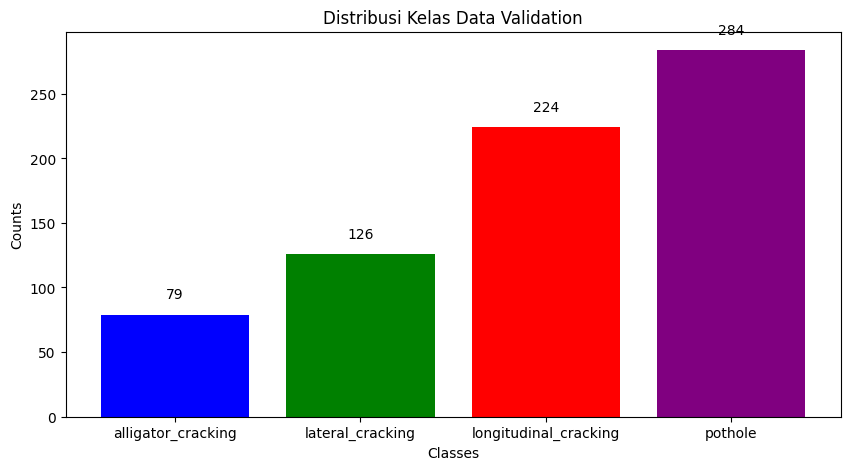

In [10]:
annotations_path = os.path.join(dataset.location, 'valid/labels')

class_names = {
    0: "alligator_cracking",
    1: "lateral_cracking",
    2: "longitudinal_cracking",
    3: "pothole"
}

class_counter = Counter()
for filename in os.listdir(annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                class_counter[class_id] += 1

# Mapping hasil ke nama kelas dan mengurutkannya
sorted_class_counts = {class_names[k]: class_counter[k] for k in sorted(class_names)}
print(sorted_class_counts)

# Membuat grafik
labels = list(sorted_class_counts.keys())
counts = list(sorted_class_counts.values())

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, counts, color=['blue', 'green', 'red', 'purple'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribusi Kelas Data Validation')
plt.show()


**Distribusi** Data Testing

{'alligator_cracking': 103, 'lateral_cracking': 121, 'longitudinal_cracking': 232, 'pothole': 266}


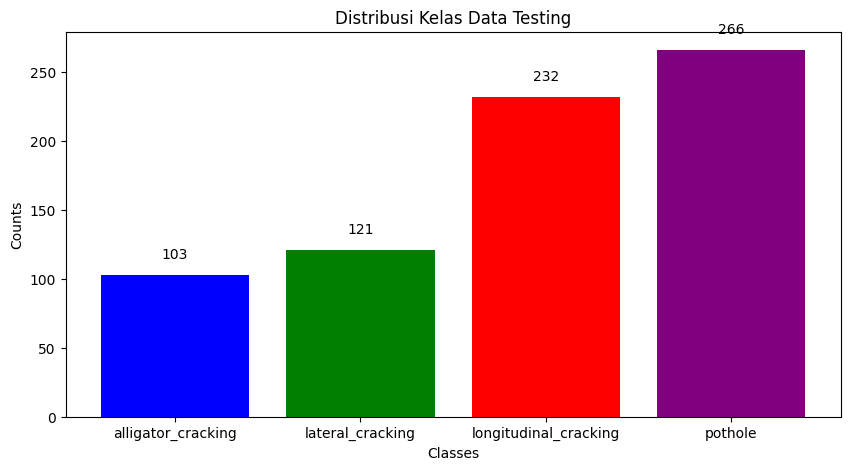

In [11]:
annotations_path = os.path.join(dataset.location, 'test/labels')

class_names = {
    0: "alligator_cracking",
    1: "lateral_cracking",
    2: "longitudinal_cracking",
    3: "pothole"
}

class_counter = Counter()
for filename in os.listdir(annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                class_counter[class_id] += 1

# Mapping hasil ke nama kelas dan mengurutkannya
sorted_class_counts = {class_names[k]: class_counter[k] for k in sorted(class_names)}
print(sorted_class_counts)

# Membuat grafik
labels = list(sorted_class_counts.keys())
counts = list(sorted_class_counts.values())

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, counts, color=['blue', 'green', 'red', 'purple'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribusi Kelas Data Testing')
plt.show()


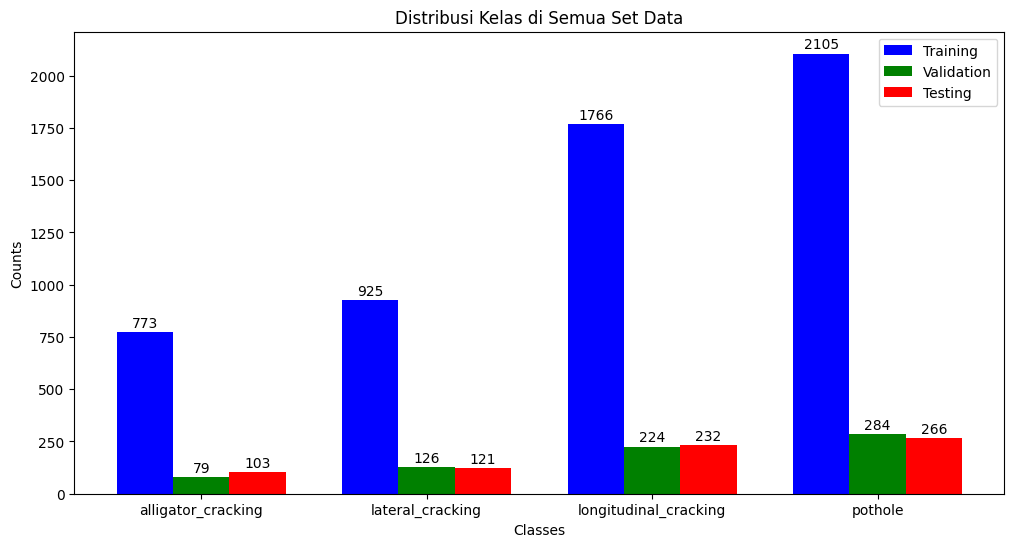

In [12]:
# prompt: gabungkan ketiga grafik diatas menjadi satu skala yang sama, dimulai dari data training, validation, dan testing

import os
from collections import Counter
import matplotlib.pyplot as plt

# Path ke folder anotasi untuk setiap set data
train_annotations_path = os.path.join(dataset.location, 'train/labels')
valid_annotations_path = os.path.join(dataset.location, 'valid/labels')
test_annotations_path = os.path.join(dataset.location, 'test/labels')

# Nama kelas
class_names = {
    0: "alligator_cracking",
    1: "lateral_cracking",
    2: "longitudinal_cracking",
    3: "pothole"
}

# Menghitung jumlah setiap kelas di setiap set data
train_class_counter = Counter()
for filename in os.listdir(train_annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(train_annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                train_class_counter[class_id] += 1

valid_class_counter = Counter()
for filename in os.listdir(valid_annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(valid_annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                valid_class_counter[class_id] += 1

test_class_counter = Counter()
for filename in os.listdir(test_annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(test_annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                test_class_counter[class_id] += 1

# Mengurutkan hasil berdasarkan nama kelas
sorted_train_class_counts = {class_names[k]: train_class_counter[k] for k in sorted(class_names)}
sorted_valid_class_counts = {class_names[k]: valid_class_counter[k] for k in sorted(class_names)}
sorted_test_class_counts = {class_names[k]: test_class_counter[k] for k in sorted(class_names)}

# Membuat grafik gabungan
labels = list(sorted_train_class_counts.keys())
train_counts = list(sorted_train_class_counts.values())
valid_counts = list(sorted_valid_class_counts.values())
test_counts = list(sorted_test_class_counts.values())

x = range(len(labels))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, train_counts, width=width, label='Training', color='blue')
plt.bar([i + width for i in x], valid_counts, width=width, label='Validation', color='green')
plt.bar([i + 2 * width for i in x], test_counts, width=width, label='Testing', color='red')

for i, (train_count, valid_count, test_count) in enumerate(zip(train_counts, valid_counts, test_counts)):
    plt.text(i, train_count + 10, int(train_count), ha='center', va='bottom')
    plt.text(i + width, valid_count + 10, int(valid_count), ha='center', va='bottom')
    plt.text(i + 2 * width, test_count + 10, int(test_count), ha='center', va='bottom')

plt.xticks([i + width for i in x], labels)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribusi Kelas di Semua Set Data')
plt.legend()
plt.show()


# Training Data

In [13]:
%cd {HOME}/yolov5

!python train.py \
--img 512 --batch 16 --epochs 150 \
--data {dataset.location}/data.yaml \
--weights yolov5s.pt \
--cache

/content/yolov5
2024-06-30 22:18:59.028614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 22:18:59.028667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 22:18:59.030126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/yolov5/Deteksi-Kerusakan-Jalan-20/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights

# Training Results

In [14]:
!ls {HOME}/yolov5/runs/train/exp/

confusion_matrix.png				    PR_curve.png	   val_batch0_pred.jpg
events.out.tfevents.1719785941.522a543f095b.5096.0  R_curve.png		   val_batch1_labels.jpg
F1_curve.png					    results.csv		   val_batch1_pred.jpg
hyp.yaml					    results.png		   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	   val_batch2_pred.jpg
labels.jpg					    train_batch1.jpg	   weights
opt.yaml					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


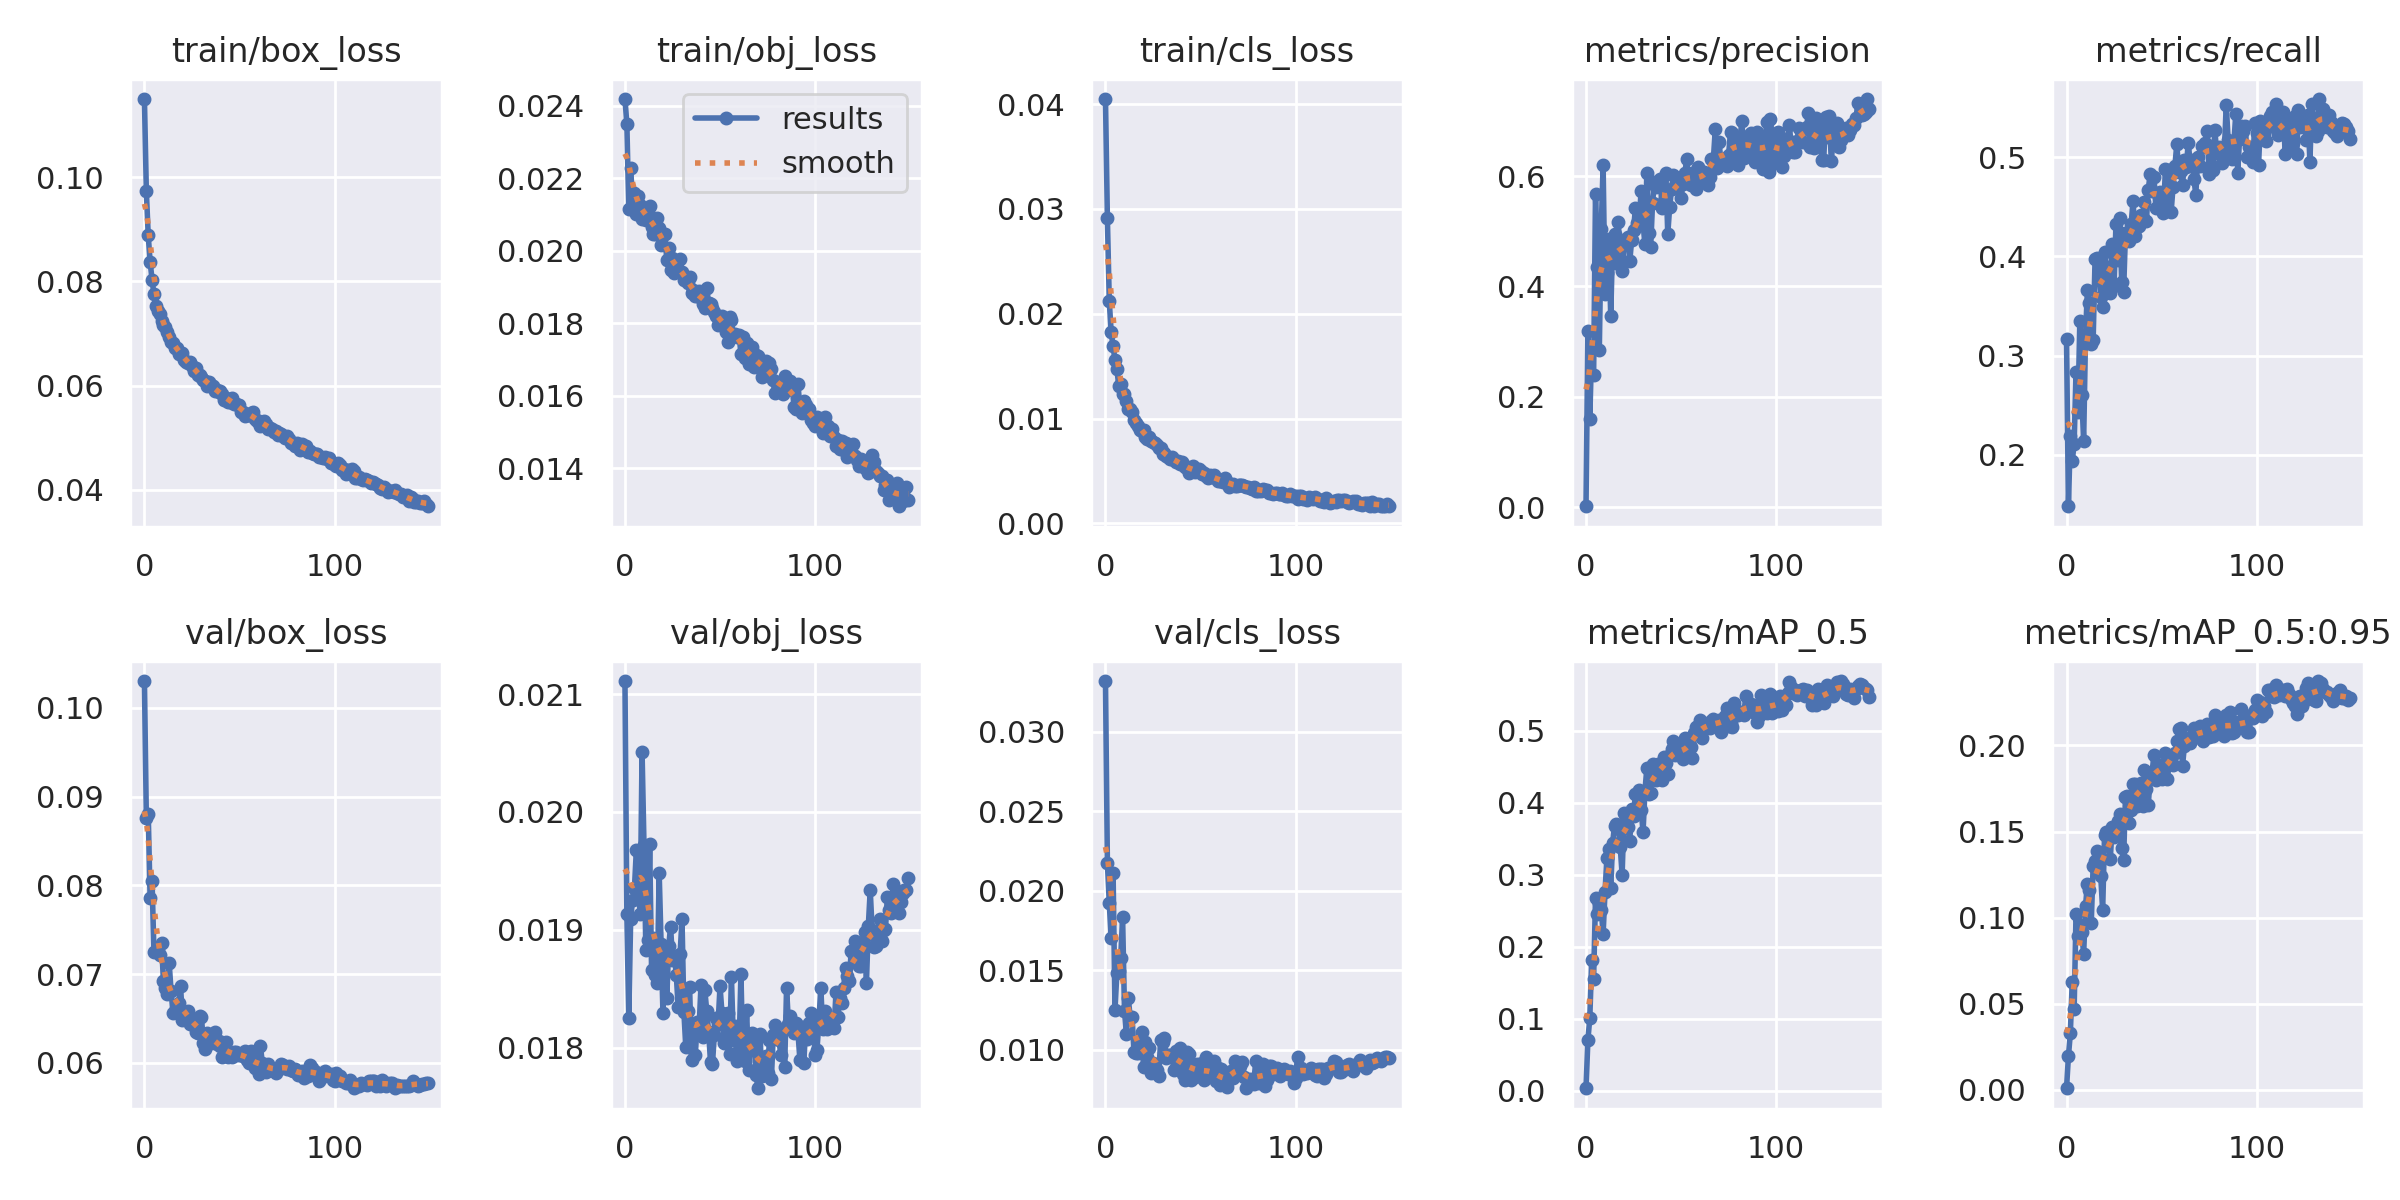

In [15]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov5/runs/train/exp/results.png", width=1000)

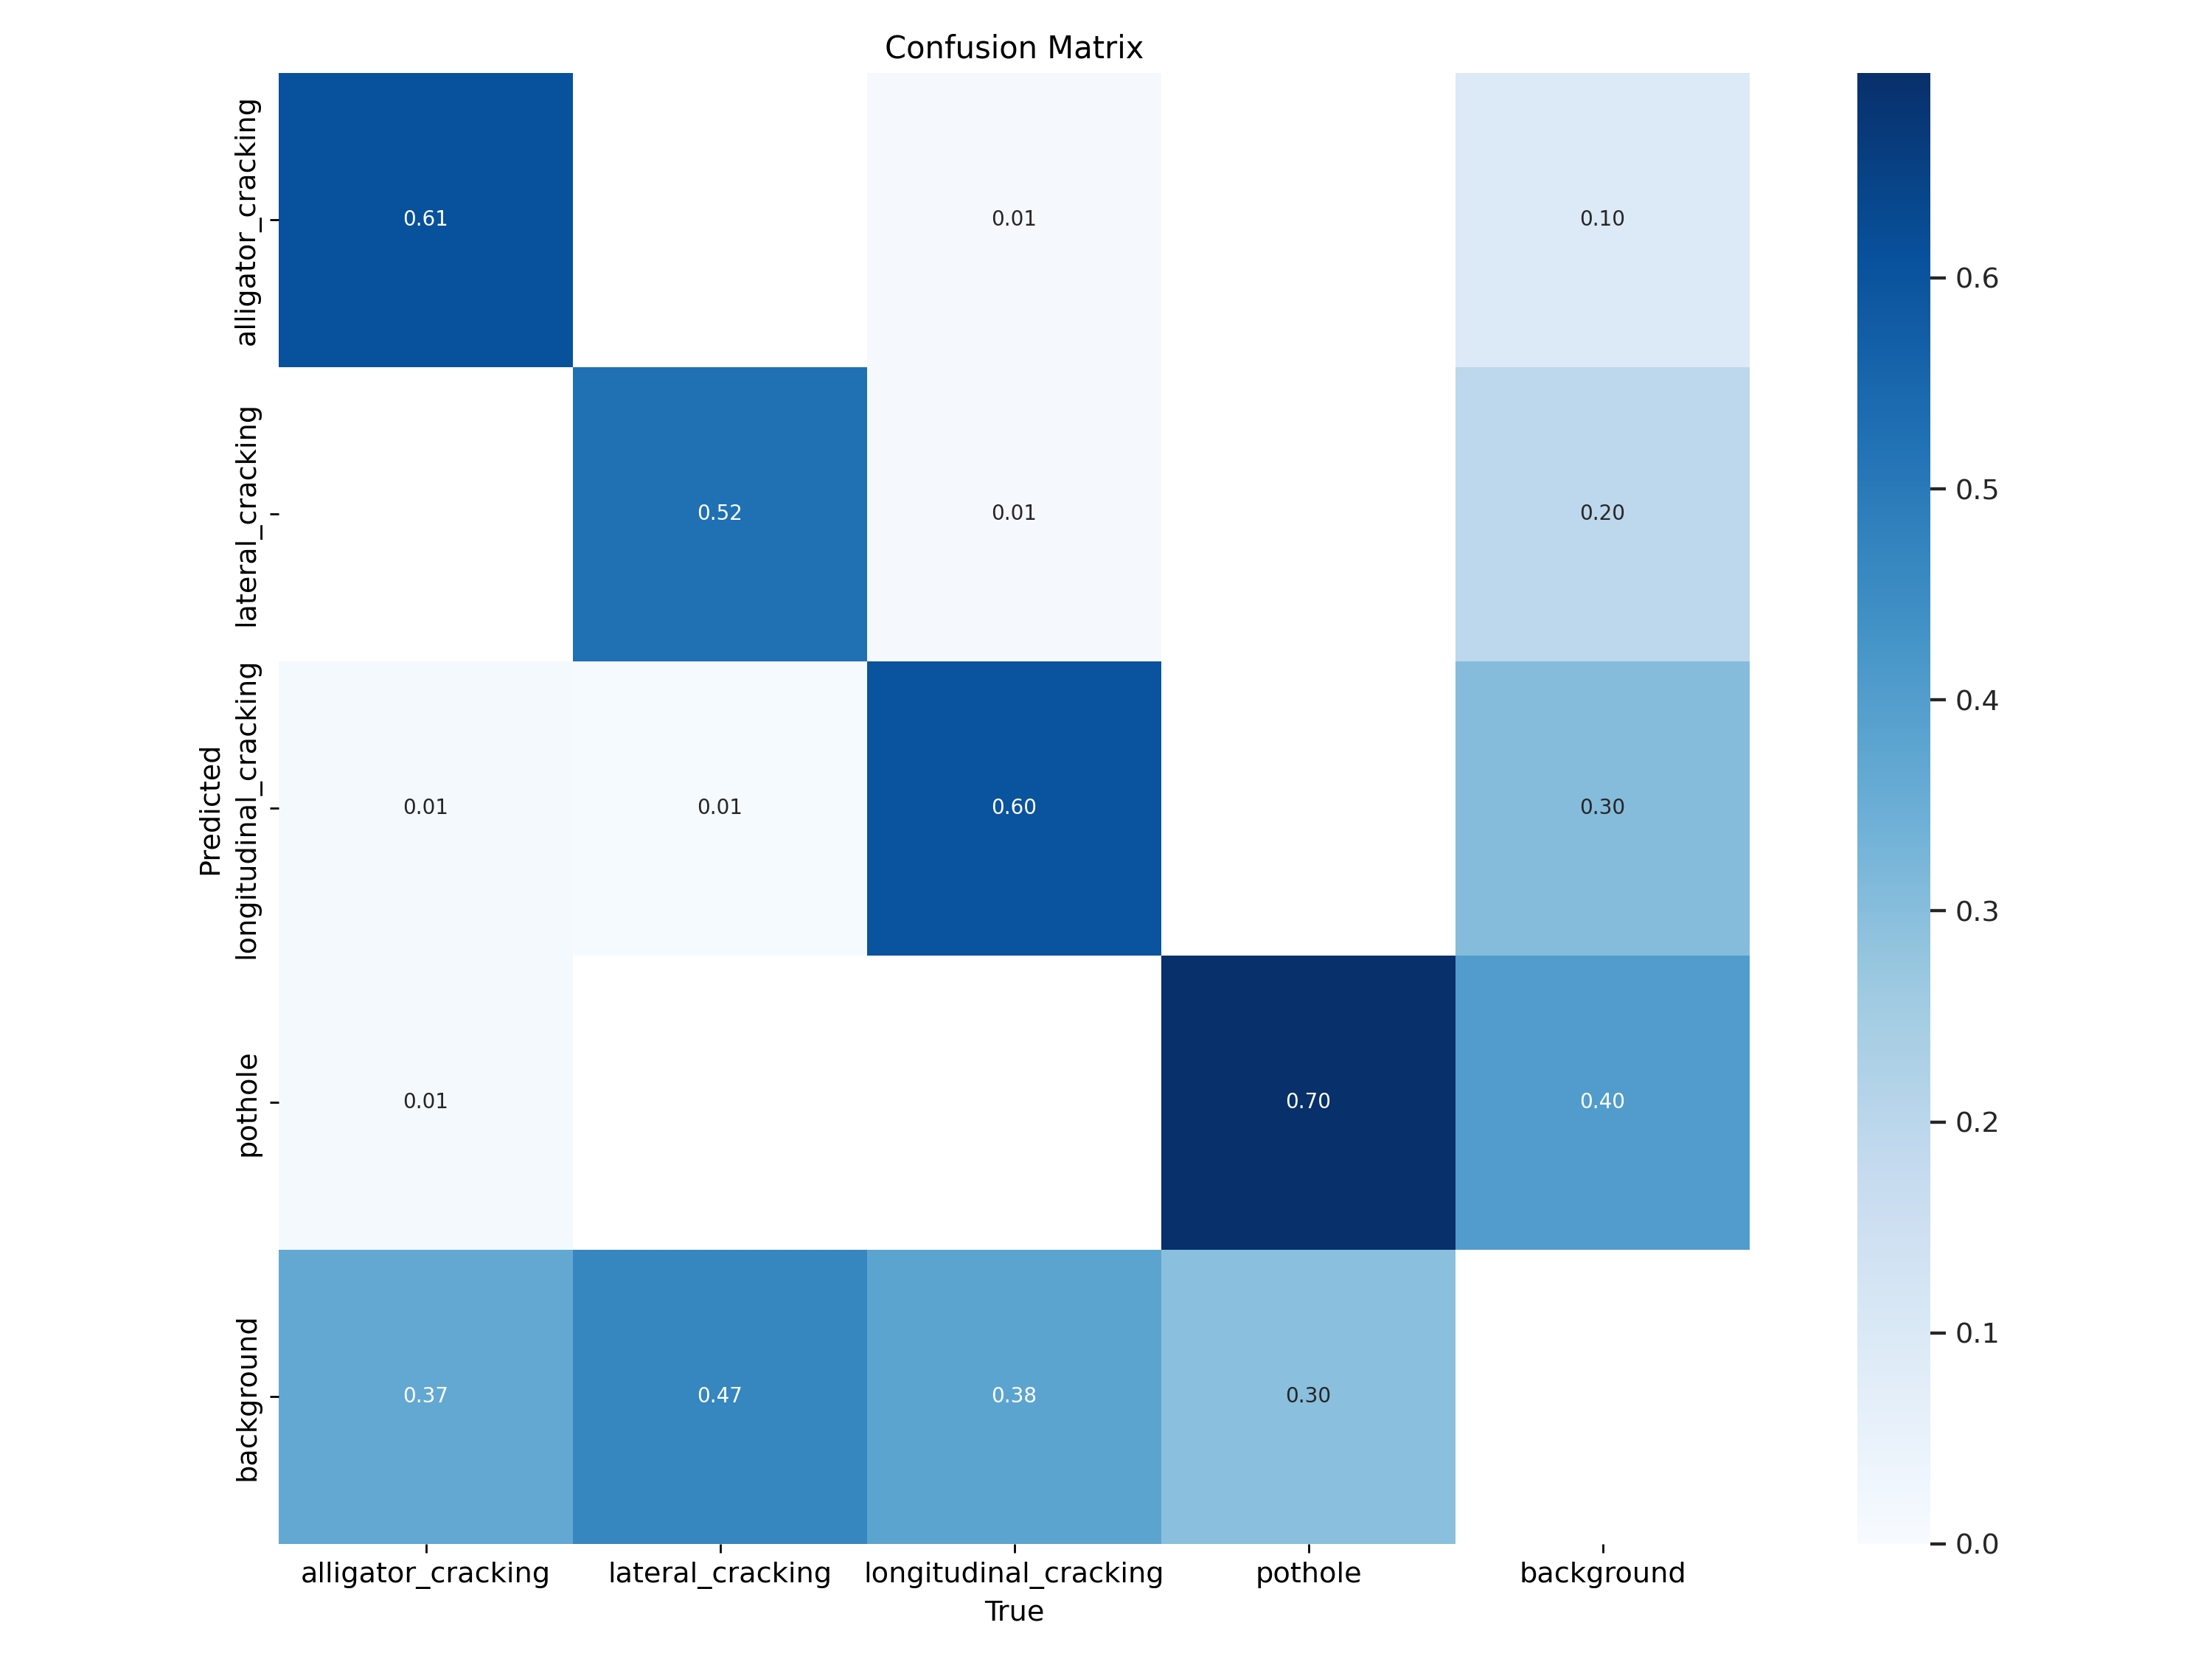

In [16]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov5/runs/train/exp/confusion_matrix.png", width=1000)

# Validation

In [17]:
%cd {HOME}/yolov5

!python val.py \
--img 512 --batch 16 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov5/runs/train/exp/weights/best.pt

/content/yolov5
val: data=/content/yolov5/Deteksi-Kerusakan-Jalan-20/data.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=16, imgsz=512, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-333-gb9019671 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/yolov5/Deteksi-Kerusakan-Jalan-20/valid/labels.cache... 333 images, 0 backgrounds, 0 corrupt: 100% 333/333 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 21/21 [00:04<00:00,  4.94it/s]
                   all        333        713      0.678      0.529      0.555      0.235
    alligator_cracking        33

# Testing

In [19]:
%cd {HOME}/yolov5

!python val.py \
--img 512 --batch 16 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov5/runs/train/exp/weights/best.pt

/content/yolov5
val: data=/content/yolov5/Deteksi-Kerusakan-Jalan-20/data.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=16, imgsz=512, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-333-gb9019671 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/yolov5/Deteksi-Kerusakan-Jalan-20/test/labels.cache... 331 images, 0 backgrounds, 0 corrupt: 100% 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 21/21 [00:04<00:00,  4.86it/s]
                   all        331        722      0.711       0.47       0.52      0.217
    alligator_cracking        331

In [21]:
%cd {HOME}/yolov5

!python val.py \
--img 512 --batch 16 --conf 0.001 --iou 0.25 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov5/runs/train/exp/weights/best.pt

/content/yolov5
val: data=/content/yolov5/Deteksi-Kerusakan-Jalan-20/data.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=16, imgsz=512, conf_thres=0.001, iou_thres=0.25, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-333-gb9019671 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/yolov5/Deteksi-Kerusakan-Jalan-20/test/labels.cache... 331 images, 0 backgrounds, 0 corrupt: 100% 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 21/21 [00:04<00:00,  5.09it/s]
                   all        331        722      0.653      0.525      0.528      0.218
    alligator_cracking        33

In [22]:
%cd {HOME}/yolov5

!python val.py \
--img 512 --batch 16 --conf 0.001 --iou 0.5 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov5/runs/train/exp/weights/best.pt

/content/yolov5
val: data=/content/yolov5/Deteksi-Kerusakan-Jalan-20/data.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=16, imgsz=512, conf_thres=0.001, iou_thres=0.5, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-333-gb9019671 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/yolov5/Deteksi-Kerusakan-Jalan-20/test/labels.cache... 331 images, 0 backgrounds, 0 corrupt: 100% 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 21/21 [00:04<00:00,  5.04it/s]
                   all        331        722      0.627      0.535      0.532      0.218
    alligator_cracking        331

# Inference Model


In [20]:
!python detect.py \
--img 512 --conf 0.1 --device 0 \
--weights {HOME}/yolov5/runs/train/exp/weights/best.pt \
--source /content/yolov5/Deteksi-Kerusakan-Jalan-20/test/images

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/yolov5/Deteksi-Kerusakan-Jalan-20/test/images, data=data/coco128.yaml, imgsz=[512, 512], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-333-gb9019671 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/331 /content/yolov5/Deteksi-Kerusakan-Jalan-20/test/images/AB_1020_jpeg.rf.60686c17f9794f0ce3f59a21c3b9a2fa.jpg: 288x512 2 longitudinal_crackings, 48.5ms
image 2/331 /content/yolov5/Deteksi-Kerusakan-Jalan-20/test/images/AB_12960_jpeg.rf.1e5219c42f672943f25700efab5e4e8a

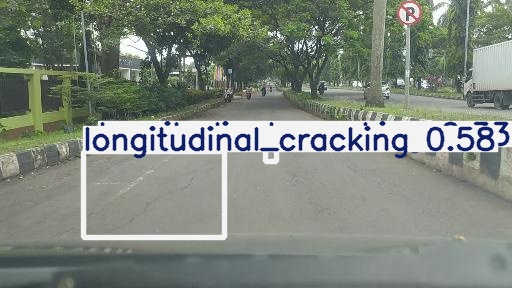

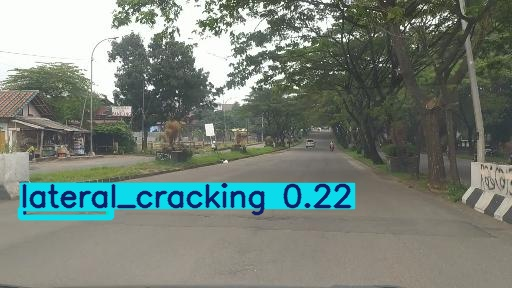

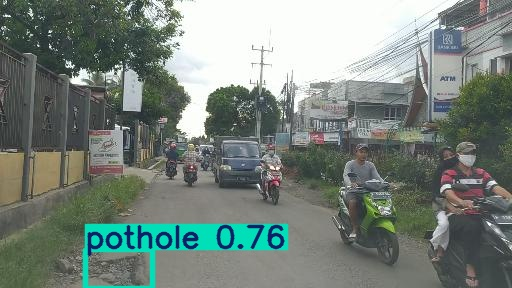

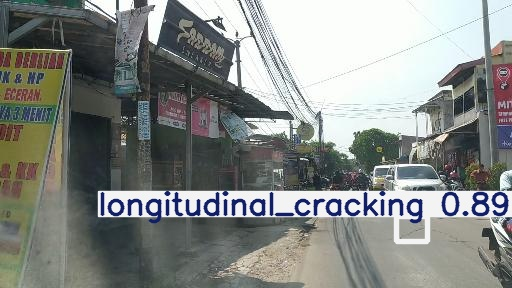

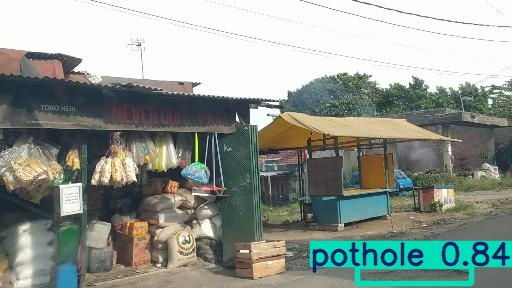

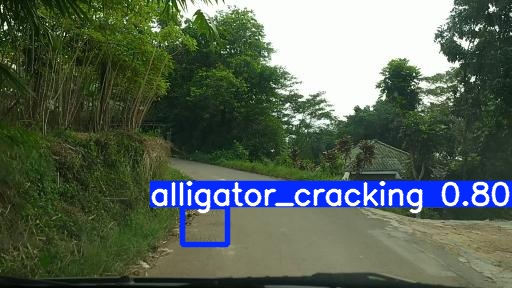

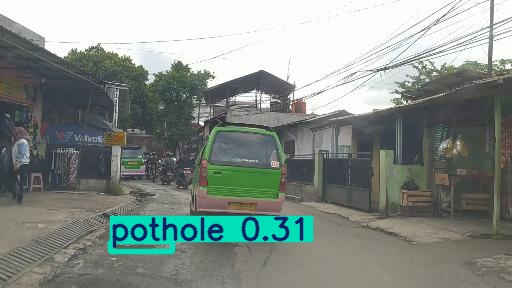

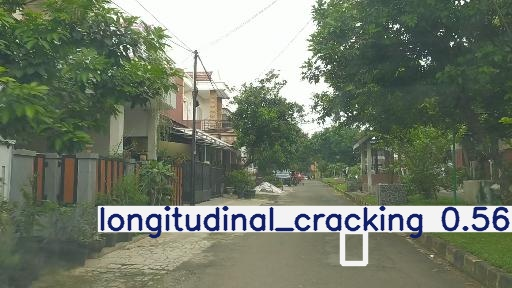

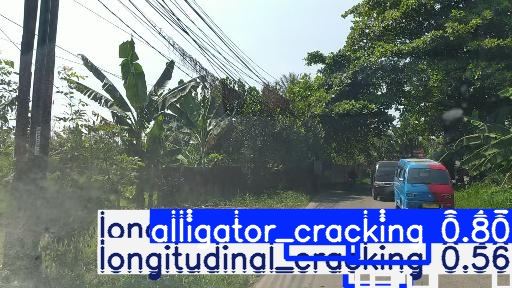

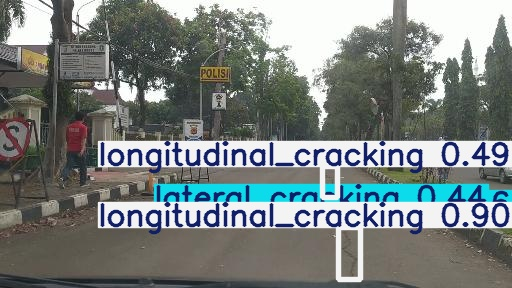

In [23]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov5/runs/detect/exp/*.jpg')[:10]:
      display(Image(filename=image_path, width=600))

# Save to Drive

In [24]:
from google.colab import drive
import os

In [25]:
# Navigate to the folder
os.chdir('/content/yolov5/runs')

# Zip the folder
!zip -r fix_skripsi_yolov5_runs_no_aug.zip .

# Move the zip file to a different location in your Google Drive
!mv fix_skripsi_yolov5_runs_no_aug.zip '/content/drive/MyDrive/Tugas_Akhir/Result'

# Optional: List files in the destination directory to confirm
!ls '/content/drive/MyDrive/Tugas_Akhir/Result'

  adding: detect/ (stored 0%)
  adding: detect/exp/ (stored 0%)
  adding: detect/exp/C_1680_jpeg.rf.bd4436663d552c0c2be5f0a876496e69.jpg (deflated 6%)
  adding: detect/exp/G_2110_jpeg.rf.4bdf4caf65367f276ed7468e903db655.jpg (deflated 5%)
  adding: detect/exp/P_34580_jpeg.rf.7b73aece03a0ecbc2b9c69e67233b03a.jpg (deflated 6%)
  adding: detect/exp/AD_16670_jpeg.rf.1b69a69c6ed2c20f86375856bad51942.jpg (deflated 4%)
  adding: detect/exp/X_17480_jpeg.rf.fadaa79cd84211dab192e1fb30ed4140.jpg (deflated 5%)
  adding: detect/exp/BI_9350_jpeg.rf.2250cf37fdce60a438cdda5cf2f4abfd.jpg (deflated 5%)
  adding: detect/exp/P_32310_jpeg.rf.9f71c33fd1ac39a1e5356147fbaac0f5.jpg (deflated 4%)
  adding: detect/exp/AB_16550_jpeg.rf.d4f687c2c9132490413f143a9d25a171.jpg (deflated 5%)
  adding: detect/exp/AD_29190_jpeg.rf.2cf8f441761654e0acb1815c4c4dd615.jpg (deflated 4%)
  adding: detect/exp/H_5290_jpeg.rf.8fb2094c9ef521d63eed691493bbdb11.jpg (deflated 4%)
  adding: detect/exp/Z_650_jpeg.rf.040718d49132f494d441b